# Análisis de datos textuales

Este tutorial es una selección y adaptación al español del libro [Text Analysis in Python for Social Scientist - Discovery and Exploration](https://www.cambridge.org/core/elements/abs/text-analysis-in-python-for-social-scientists/BFAB0A3604C7E29F6198EA2F7941DFF3) de Dirk Hovy. 

Para este tutorial, vamos a cargar los paquetes nltk y spacy:

In [1]:
import nltk
import spacy

nltk.download("stopwords")
nltk.download("punkt")
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


También abriremos un libro del proyecto Gutenberg: 

In [2]:
from urllib.request import urlopen

url = "https://www.gutenberg.org/files/21282/21282-8.txt"
raw = urlopen(url).read().decode("ISO-8859-1")

## Información mutua puntual (Pointwise Mutual Information)

Intuitivamente, nos gustaría tratar términos como "redes sociales", "Nueva York" o "emisión de gases de efecto invernadero" como un concepto único, en lugar de tratarlos como unidades individuales delimitadas por espacios en blanco. Sin embargo, mirar la frecuencia de las dos palabras juntas no es suficiente. 

Piensa en los elementos de "Nueva York" (mientras que "York" probablemente no sea demasiado frecuente, "Nueva" definitivamente lo es). Dejar estas palabras aparte o unirlas tendrá un gran impacto en nuestros hallazgos. ¿Cómo unimos las palabras correctas?



Sin embargo, palabra es un concepto blando. Hemos visto que los espacios en blanco son más un efecto visual opcional que un límite significativo de palabras (por ejemplo, el chino no los usa). En español, tenemos conceptos que incluyen varias palabras, pero que ya no analizaríamos como componentes separados. 

Piensa en nombres de lugares como "Los Ángeles" y "San Luis Obispo", pero también en conceptos como "redes sociales". (Si no está de acuerdo con esto último, es porque el proceso, llamado gramaticalización, es gradual y, en este caso, no se ha completado por completo). 

Si bien todavía es evidente lo que significan las partes, se han vinculado inextricablemente entre sí. Estos pares de palabras se denominan **colocaciones**.


Cuando trabajamos con texto, a menudo es mejor tratar las colocaciones como una entidad, en lugar de como unidades separadas. 

Para ello, podemos calcular la probabilidad de que cada palabra ocurra por sí sola, pero esto no ayuda mucho: es mucho más probable que ocurra "Nueva" que "York". Necesitamos relacionar estas cantidades con la probabilidad de que las dos palabras aparezcan juntas. 

Si alguna (o todas) de las palabras candidatas aparecen en el contexto de las demás, tenemos motivos para creer que se trata de una colocación, p. Ej., "Ángeles" en el caso de "Los Ángeles". Si, por otro lado, cualquier palabra tiene la misma probabilidad de ocurrir de forma independiente, probablemente no tengamos una colocación, por ejemplo, "de" y "el" en "de".

Aplicar la detección de colocación a un corpus de ejemplo en Python es mucho más fácil, ya que hay algunas funciones implementadas en NLTK que nos salvan de calcular todas las tablas de probabilidad:

In [3]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords

documents = raw[1500:286409]
documents = [str(sentence) for sentence in nlp(documents).sents]

# Quita stopwords
stopwords_ = set(stopwords.words("spanish"))

words = [
    word.lower()
    for document in documents
    for word in document.split()
    if len(word) > 2 and word not in stopwords_
]

# Encontrar colocaciones con NLTK
finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
collocations = {
    bigram: pmi for bigram, pmi in finder.score_ngrams(bgm.mi_like)
}
collocations

{('crónica', 'época'): 3.937869822485207,
 ('_rey', 'monte_'): 3.5714285714285716,
 ('--¡ay,', 'ay!'): 3.0,
 ('_papeles', 'varios_'): 3.0,
 ('ay!', '¡tan'): 3.0,
 ('eran:', 'escudo'): 2.7777777777777777,
 ('excelentísimo', 'señor'): 2.1783960720130935,
 ('maestro', 'lucas'): 2.1333333333333333,
 ('época', 'del'): 2.1330128205128207,
 ('_huerta', 'perdida_.'): 2.0,
 ('callejón', 'petateros.'): 2.0,
 ('comerlo', 'beberlo,'): 2.0,
 ('demonios', 'coronados,'): 2.0,
 ('dígase', 'quiera'): 2.0,
 ('francisca', 'henríquez'): 2.0,
 ('gentilhombre', 'cámara'): 2.0,
 ('guantes', 'gamuza,'): 2.0,
 ('lorente,', '_historia_,'): 2.0,
 ('nadar,', 'peces!'): 2.0,
 ('peseta', 'columnaria'): 2.0,
 ('plena', 'tiniebla,'): 2.0,
 ('portal', 'botoneros'): 2.0,
 ('portocarrero', 'lazo'): 2.0,
 ('retiróse', 'mohino'): 2.0,
 ('rienda', 'suelta'): 2.0,
 ('varios_', 'biblioteca'): 1.8,
 ('reales', 'ejércitos,'): 1.6,
 ('_mama_', 'salomé,'): 1.5,
 ('don', 'josé'): 1.4797687861271676,
 ('teniente', 'general'): 1.45

El primer código crea una larga lista de cadenas del corpus, eliminando todas las palabras vacías y las palabras de menos de dos caracteres (eliminando así la puntuación). Luego crea un objeto BigramCollocationFinder, inicializado con la lista de palabras. 

De este objeto, podemos extraer las estadísticas. Aquí, usamos una variante de PMI, llamada mi_like, que no toma el logaritmo, pero usa un exponente.

>Hasta aquí hemos visto ejemplos de preprocesamiento, para eliminar el ruido y las variaciones innecesarias y para aumentar la cantidad de señal en los datos. Todos estos pasos se pueden combinar, por lo que obtenemos una versión mucho más homogénea y menos ruidosa de nuestro corpus de entrada. Sin embargo, **no existe una regla general sobre qué pasos excluir y cuáles conservar**.

>En última instancia, qué conjunto de pasos de preprocesamiento aplicar **depende en gran medida de la tarea y los objetivos**. Tiene sentido probar diferentes combinaciones en un conjunto de desarrollo separado y reservado, y observar cuál da los mejores resultados. Más importante aún, las decisiones de preprocesamiento siempre cambian el texto y, por lo tanto, afectan las inferencias que podemos hacer. Debemos ser conscientes de este efecto, y debemos justificar y documentar todos los pasos previos al procesamiento y las decisiones que hemos tomado (cf. Denny y Spirling, 2018).

## Conteo

Una primera forma de analizar nuestros datos textuales es a través de un conteo simple de palabras:


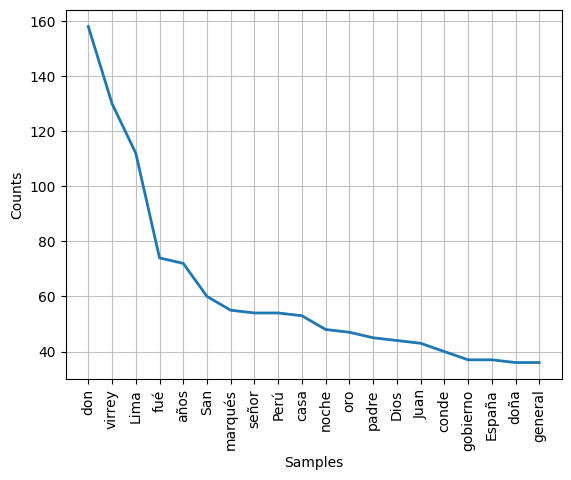

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
import nltk

documents = raw[1500:286409]

# Remove stopwords
content = [
    [
        token.text
        for token in sentence
        if token.pos_ in {"NOUN", "VERB", "PROPN", "ADJ", "ADV"}
        and not token.is_stop
    ]
    for sentence in nlp(documents).sents
]

# Get tokens
tokens = []
for i in content:
    tokens += i
while "_" in tokens:
    tokens.remove("_")  # Removes strange character

# Create text object
text = nltk.Text(tokens)

# Plot most frequent words
text.plot(20)

### Nube de palabras

Una manera más amable de observar las palabras más frecuentes es a través de una nube de palabras:

In [12]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud


def create_wordcloud(text):
    stopwords_ = set(stopwords.words("spanish"))
    mask = np.array(Image.open("cloud.png"))

    wc = WordCloud(
        background_color="white",
        mask=mask,
        max_words=300,
        stopwords=stopwords_,
        collocations=False,
    )
    wc.generate(str(text))
    wc.to_file("wc.png")
    path = "wc.png"
    display(Image.open(path))

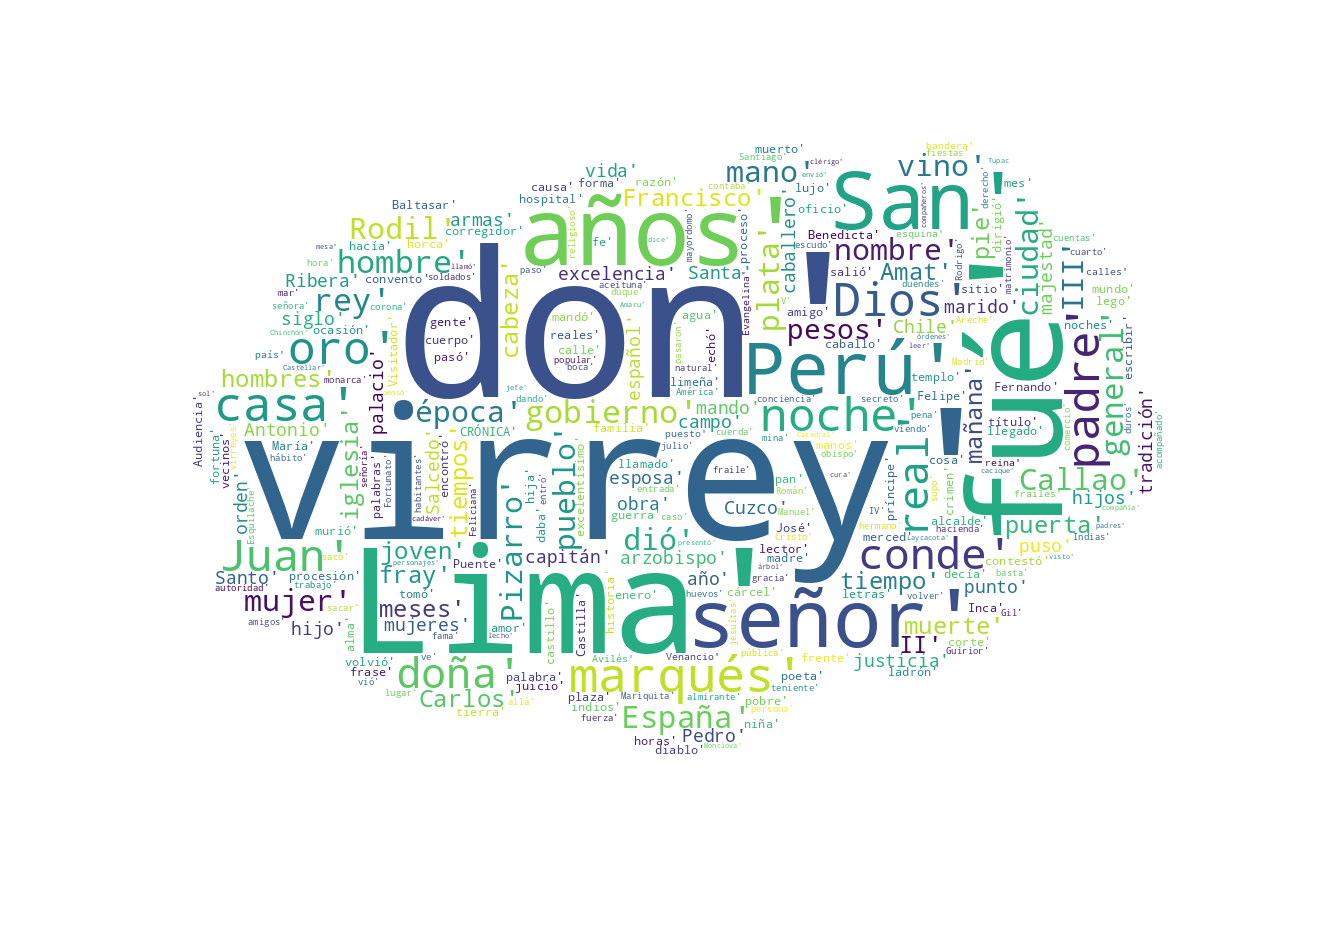

In [13]:
# Creating wordcloud for all tweets
create_wordcloud(tokens)

## Conteo TF-IDF

El conteo de palabras es un buen comienzo, pero da el mismo peso a todos los términos con la misma frecuencia. Sin embargo, algunos términos son más "interesantes" que otros, incluso si tienen las mismas o menos ocurrencias. 

Supongamos que tenemos 500 empresas y, para cada una de ellas, informes anuales de varios años. Los informes recopilados de cada empresa son un documento. No nos sorprenderá encontrar las palabras “informe” o “empresa” entre los términos más frecuentes, ya que seguramente se utilizarán en todos los documentos. 

Sin embargo, si solo algunas de esas empresas utilizan la "sostenibilidad", pero lo hacen de forma coherente en todos los informes, esta sería una señal muy interesante que vale la pena descubrir. ¿Cómo captar esta noción?


La respuesta es sopesar la frecuencia bruta (su **frecuencia de término**, o TF) por el número de documentos en los que aparece la palabra (su **frecuencia de documento** o IDF). De esta forma, las palabras que aparecen con frecuencia, pero en todos los documentos (como las palabras funcionales), recibirán puntuaciones muy bajas. También lo serán las palabras que son raras, pero que podrían aparecer en todas partes (digamos, “presidente” en nuestro ejemplo: no es frecuente, pero será mencionado en todos los informes). 

Las palabras que son moderadamente frecuentes pero que aparecen en solo unos pocos documentos obtienen la puntuación más alta, y estas palabras son lo que buscamos. Podemos obtener ambas cantidades de una matriz de conteo discreta. El TF es la suma sobre la columna correspondiente de la matriz, mientras que el DF es el recuento de las entradas distintas de cero en esa columna.

Al graficar los valores de IDF versus TF-IDF, y escalar por TF, podemos ver cómo se distribuyen las palabras ininterrumpidas en un corpus.

Para ello, en Python podemos usar TfidfVectorizer en sklearn:

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = raw[1500:286409]

# Remove stopwords and order by sentences
content_sentences = [
    " ".join(
        [
            token.text
            for token in sentence
            if token.pos_ in {"NOUN", "VERB", "PROPN", "ADJ", "ADV"}
            and not token.is_stop
        ]
    )
    for sentence in nlp(documents).sents
]

stopwords_ = set(stopwords.words("spanish"))

tfidf_vectorizer = TfidfVectorizer(
    analyzer="word",
    min_df=0.001,
    max_df=0.75,
    stop_words=stopwords_,
    sublinear_tf=True,
)
X = tfidf_vectorizer.fit_transform(content_sentences)

Esto devuelve una matriz de datos con una fila para cada documento y los valores transformados en las celdas. Podemos obtener los valores IDF de la propiedad `idf_` del vectorizador. Para obtener los valores TF-IDF de una determinada característica para todo el corpus, podemos sumar todas las filas/documentos. La propiedad A1 convierte la matriz dispersa en una matriz regular:

In [15]:
idf = tfidf_vectorizer.idf_
tfidf = X.sum(axis=0).A1

Luego, generamos el gráfico:

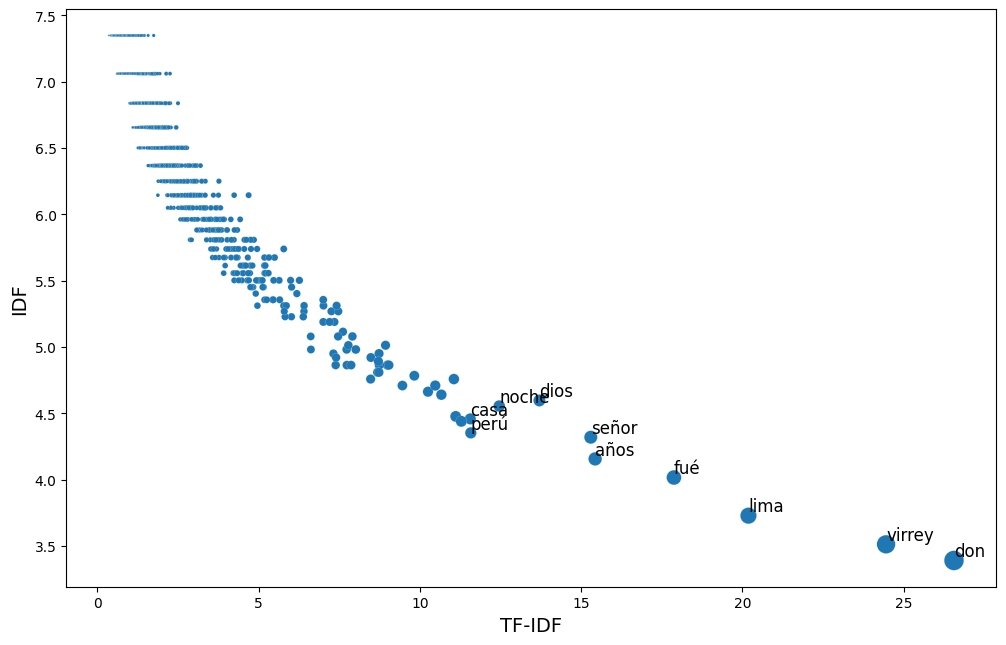

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7.5))
sns.scatterplot(x=tfidf, y=idf, size=tfidf / idf, legend=False, sizes=(1, 200))
plt.xlabel("TF-IDF", size=14)
plt.ylabel("IDF", size=14)
names = tfidf_vectorizer.get_feature_names_out()
top = (tfidf / idf).argsort()[-10:]
for i in top:
    plt.text(tfidf[i], idf[i], str(names[i]), size=12, va="bottom", ha="left")

In [23]:
names[top]

array(['casa', 'perú', 'noche', 'dios', 'señor', 'años', 'fué', 'lima',
       'virrey', 'don'], dtype=object)

 El gráfico muestra las palabras de contenido en Tradiciones Peruanas. Se etiquetan las cinco palabras con las puntuaciones TF-IDF más altas. Si bien la prevalencia de "virrey" no es sorprendente (el TF-IDF está dominado por el TF alto, pero es un libro de ficciones históricas), podemos ver un par de entradas interesantes como "Lima" y "Don", que sugieren el tenor y la localización de los relatos.

Si tienes tiempo, te invito a revisar el contenido de los libros [Text Analysis in Python for Social Scientists – Discovery and Exploration](https://www.cambridge.org/core/elements/abs/text-analysis-in-python-for-social-scientists/BFAB0A3604C7E29F6198EA2F7941DFF3) y [Twitter as Data](https://www.cambridge.org/core/elements/abs/twitter-as-data/27B3DE20C22E12E162BFB173C5EB2592).

Además, te invito a revisar la técnica [Sentiment Analysis](https://realpython.com/python-nltk-sentiment-analysis/#using-nltks-pre-trained-sentiment-analyzer).